In [415]:
library(dplyr)
library(stringr)
library(readr)
library(tidyr)
library(lfe)
library(scales)
library(repr)
library(stargazer)
options(repr.plot.width=7, repr.plot.height=7, digits=3)
source('~/covid_mobility/paper_code/utils/adjacency_and_cluster_robust_inference.R')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/data.RData')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/social_adj_matrix.RData')
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/geo_adjacency_matrix.Rdata')
source('~/covid_mobility/paper_code/data_cleaning/residualizer+genAlters.R')


In [416]:
source("../utils/labels_and_colors.r")
source("../utils/geo_utils.r")
source("../utils/adjacency_and_cluster_robust_inference.R")
source("../utils/contrasts.r")

In [417]:
dates <- data.frame(ds = unique(panel$ds))

In [418]:
fips <- data.frame(county_fips = as.integer(as.character(colnames(WM))))

In [419]:
head(panel$sg_mcbgv)

[1] 2.47 2.15 2.13 2.37 2.46 2.03

In [420]:
panel %>%
  mutate(cbgv = (non_home_cbg_visits_within_county + cbg_visits_outside_county +
                                  home_cbg_visits)/device_count) %>%
  mutate(log_sg_nhd = log(sg_nhd),
         log_sg_cbgv = log(cbgv),
         log_fb_rnstu = log(fb_rnstu)) -> panel

panel.r$sg_nhd.r <- unlist(panel_residualizer('sg_nhd'))
panel.r$sg_cbgv.r <- unlist(panel_residualizer('sg_mcbgv'))
panel.r$fb_rnstu.r <- unlist(panel_residualizer('fb_rnstu'))

panel.r$log_sg_nhd.r <- unlist(panel_residualizer('log_sg_nhd'))
panel.r$log_sg_cbgv.r <- unlist(panel_residualizer('log_sg_cbgv'))
panel.r$log_fb_rnstu.r <- unlist(panel_residualizer('log_fb_rnstu'))
panel.r$sh_geo_alter.r <- unlist(panel_residualizer('geo_alter_sh'))

[1]	train-rmse:0.252427+0.000301	test-rmse:0.252489+0.001328 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:0.129167+0.000230	test-rmse:0.129479+0.001364 
[3]	train-rmse:0.069474+0.000265	test-rmse:0.070013+0.001532 
[4]	train-rmse:0.042634+0.000312	test-rmse:0.043534+0.001397 
[5]	train-rmse:0.032136+0.000373	test-rmse:0.033417+0.001222 
[6]	train-rmse:0.028615+0.000365	test-rmse:0.030141+0.001054 
[7]	train-rmse:0.027395+0.000380	test-rmse:0.029154+0.000942 
[8]	train-rmse:0.026838+0.000376	test-rmse:0.028795+0.000776 
[9]	train-rmse:0.026479+0.000377	test-rmse:0.028570+0.000688 
[10]	train-rmse:0.026149+0.000399	test-rmse:0.028356+0.000639 
[11]	train-rmse:0.025866+0.000382	test-rmse:0.028267+0.000592 
[12]	train-rmse:0.025647+0.000359	test-rmse:0.028240+0.000682 
[13]	train-rmse:0.025450+0.000358	test-rmse:0.028272+0.000621 
[14]	train-rmse:0.025265+0.000384	test-rmse:0.028236+0.0006

[1]	train-rmse:0.265486+0.000045	test-rmse:0.266122+0.001665 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:0.151119+0.000369	test-rmse:0.152513+0.001320 
[3]	train-rmse:0.103211+0.000668	test-rmse:0.106009+0.000748 
[4]	train-rmse:0.086359+0.000657	test-rmse:0.090175+0.000211 
[5]	train-rmse:0.080882+0.000697	test-rmse:0.085103+0.000651 
[6]	train-rmse:0.078766+0.000728	test-rmse:0.083534+0.000725 
[7]	train-rmse:0.077665+0.000742	test-rmse:0.083218+0.000665 
[8]	train-rmse:0.076982+0.000776	test-rmse:0.082710+0.000484 
[9]	train-rmse:0.076330+0.000668	test-rmse:0.082509+0.000341 
[10]	train-rmse:0.075653+0.000723	test-rmse:0.082520+0.000269 
[11]	train-rmse:0.075186+0.000793	test-rmse:0.082575+0.000361 
[12]	train-rmse:0.074619+0.000797	test-rmse:0.082591+0.000429 
Stopping. Best iteration:
[9]	train-rmse:0.076330+0.000668	test-rmse:0.082509+0.000341



In [421]:
fips_in_panel <- as.character(unique(panel.r$county_fips))
indices <- which(colnames(social_adj_matrix) %in% fips_in_panel)
social_adj_matrix_for_conley <- social_adj_matrix[indices, indices]
diag(social_adj_matrix_for_conley) <- 1
n_ds <- length(seq(as.Date('2020-03-01'), as.Date('2020-04-18'), 1))
matrix_list <- lapply(seq_len(n_ds), function(X) social_adj_matrix_for_conley)
AM <- bdiag(matrix_list)
rm(matrix_list)

## Exploration of variation in alter policies

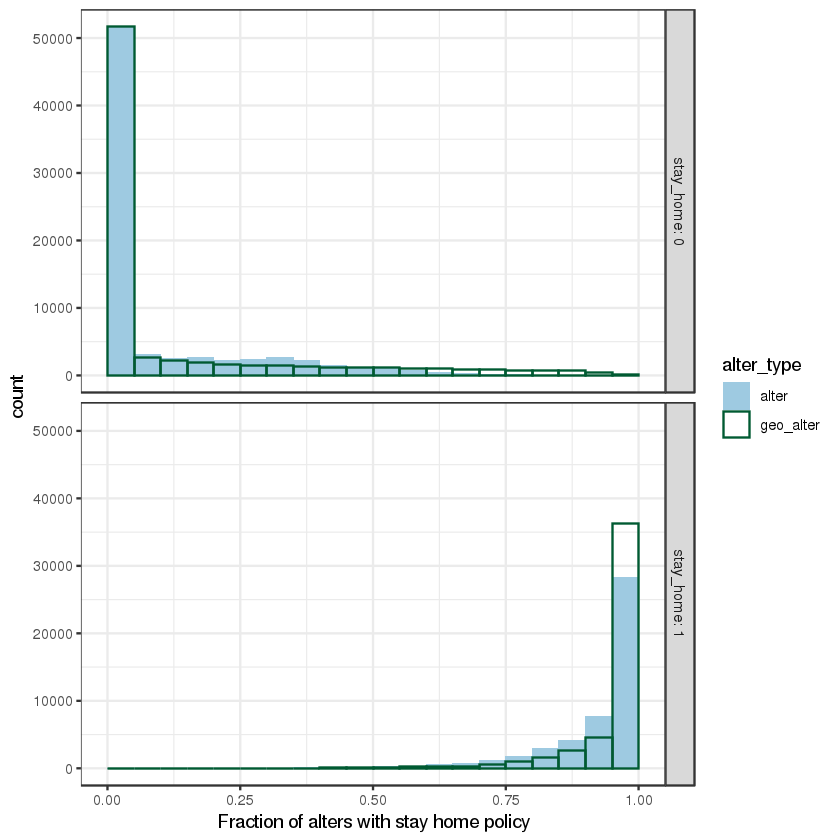

In [422]:
alter_stay_home_histograms <- panel %>%
    select(stay_home, alter_sh, geo_alter_sh) %>%
    gather(key = "alter_type", value = "alter_sh", -stay_home) %>%
    mutate(
        alter_type = gsub("_sh", "", alter_type)
    ) %>%
    ggplot(aes(x = alter_sh, fill = alter_type, color = alter_type)) +
    geom_histogram(breaks = seq(0, 1, by = .05), position = 'identity') +
    facet_grid(stay_home ~ ., labeller = label_both) +
    scale_fill_manual(values = alpha(alter_type_fills, c(1, 0, 0, 0))) +
    scale_color_manual(values = alpha(alter_type_colors, c(0, 1, 0, 0))) +
    xlab("Fraction of alters with stay home policy")
alter_stay_home_histograms

In [423]:
# For some reason at most 90% of geo alters have stay at home... TODO

In [424]:
ggsave(
  paste0("../output/alter_stay_home_histograms.pdf"),
  plot = alter_stay_home_histograms,
  scale = 1.2,
  width = 5,
  height = 5,
  limitsize = FALSE,
  useDingbats = FALSE
)

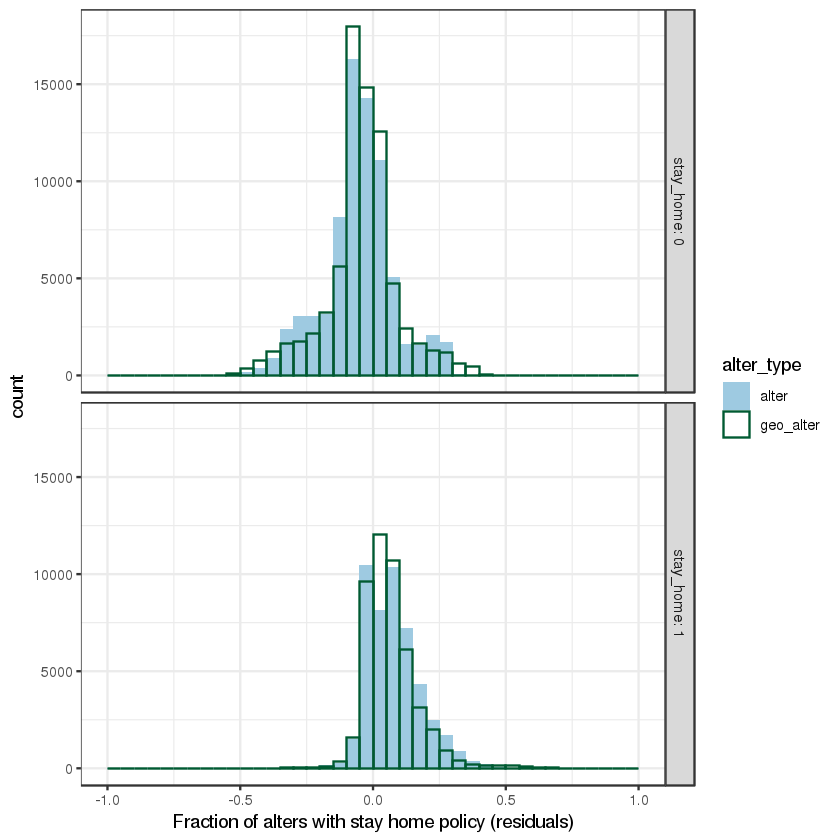

In [425]:
alter_stay_home_residual_histograms <- panel.r %>%
    mutate(
        stay_home = panel$stay_home
    ) %>%
    select(stay_home, alter_sh.r, geo_alter_sh.r) %>%
    gather(key = "alter_type", value = "alter_sh.r", -stay_home) %>%
    mutate(
        alter_type = gsub("_sh.r", "", alter_type)
    ) %>%
    ggplot(aes(x = alter_sh.r, fill = alter_type, color = alter_type)) +
    geom_histogram(breaks = seq(-1, 1, by = .05), position = 'identity') +
    facet_grid(stay_home ~ ., labeller = label_both) +
    scale_fill_manual(values = alpha(alter_type_fills, c(1, 0, 0, 0))) +
    scale_color_manual(values = alpha(alter_type_colors, c(0, 1, 0, 0))) +
    xlab("Fraction of alters with stay home policy (residuals)")
alter_stay_home_residual_histograms

In [426]:
ggsave(
  paste0("../output/alter_stay_home_residual_histograms.pdf"),
  plot = alter_stay_home_residual_histograms,
  scale = 1.2,
  width = 5,
  height = 5,
  limitsize = FALSE,
  useDingbats = FALSE
)

## Making within- and between-state matrices and variables
We need to decompose alters as within and between states for many contrasts

In [427]:
# function taken from produce_panel_data_v2.ipynb 
weightedAlters <- function(wm, colname = NA, df = df, ...) {
    df %>% 
        select(ds, county_fips, ...) %>%
        spread(key = county_fips, value = ...) %>%
        ungroup() %>%
        select(-ds) %>%
        as.matrix() -> txn_data
    
    outMatrix <- tcrossprod(txn_data, wm)
    colnames(outMatrix) <- fips$county_fips
    
    data.frame(dates, outMatrix) %>%
        gather(key = 'county_fips', value = 'value', -ds) %>%
        mutate(county_fips = as.integer(str_sub(county_fips, 2, -1))) %>% 
        arrange(ds, county_fips) %>%
        select(-ds, -county_fips) -> out_df
    if (is.null(colname)) {
        return(out_df[, 1])
    } else {
        colnames(out_df)[1] <- colname
        return(out_df)
    }
}

In [428]:
same_state_matrix = do.call(rbind, lapply(
    colnames(WM),
    function(i) state_code_from_fips(i) == state_code_from_fips(colnames(WM))
    ))

In [429]:
# matrix for only same-state SCI peers
WM_same_state <- same_state_matrix * WM
WM_diff_state <- WM - WM_same_state

In [430]:
# creating geo WM, borrowed from produce_panel_data_v2.ipynb
colnames(geo_adj_matrix_bayes) <- rownames(geo_adj_matrix_bayes)
as.data.frame(geo_adj_matrix_bayes) %>%
    mutate(origin_county = rownames(geo_adj_matrix_bayes)) %>%
    gather(key = 'dest_county', value = 'w', -origin_county) %>%
    mutate(origin_county = as.numeric(origin_county),
           dest_county = as.numeric(dest_county),
           w = ifelse(origin_county == dest_county, 0 , w)) %>%
    inner_join(fips, by = c('origin_county' = 'county_fips')) %>%
    inner_join(fips, by = c('dest_county' = 'county_fips')) %>%
    group_by(dest_county) %>%
    mutate(w = w / sum(w)) %>%
    spread(key = origin_county, value = w) %>%
    ungroup() %>%
    select(-dest_county) %>%
    as.matrix() -> gWM

In [431]:
load('/nfs/sloanlab004/projects/covid_mobility_proj/data/PROCESSED_DATA/geo_adjacency_matrix.Rdata')
as.data.frame(geo_adj_matrix_bayes_counts) %>%
    mutate(origin_county = rownames(geo_adj_matrix_bayes_counts)) %>%
    gather(key = 'dest_county', value = 'w', -origin_county) %>%
    mutate(origin_county = as.numeric(origin_county),
           dest_county = as.numeric(dest_county),
           w = ifelse(origin_county == dest_county, 0 , w)) %>%
    inner_join(fips, by = c('origin_county' = 'county_fips')) %>%
    inner_join(fips, by = c('dest_county' = 'county_fips')) %>%
    group_by(dest_county) %>%
    mutate(w = w / sum(w)) %>%
    spread(key = origin_county, value = w) %>%
    ungroup() %>%
    select(-dest_county) %>%
    as.matrix() -> gWM

In [432]:
gWM_same_state <- same_state_matrix * gWM
gWM_diff_state <- gWM - gWM_same_state

In [446]:
names(panel)

[1] "ds"                                 
  [2] "county_fips"                        
  [3] "sg_nhd"                             
  [4] "state_abbv"                         
  [5] "stay_home"                          
  [6] "PRCP"                               
  [7] "TMAX"                               
  [8] "n11"                                
  [9] "n21"                                
 [10] "n22"                                
 [11] "n23"                                
 [12] "n31"                                
 [13] "n32"                                
 [14] "n33"                                
 [15] "n42"                                
 [16] "n44"                                
 [17] "n45"                                
 [18] "n48"                                
 [19] "n49"                                
 [20] "n51"                                
 [21] "n52"                                
 [22] "n53"                                
 [23] "n54"                                
 [24] "n55"                                
 [25] "n56"                                
 [26] "n61"                                
 [27] "n62"                                
 [28] "n71"                                
 [29] "n72"                                
 [30] "n81"                                
 [31] "n92"                                
 [32] "nNA"                                
 [33] "fb_btvrc"                           
 [34] "fb_rnstu"                           
 [35] "n"                                  
 [36] "device_count"                       
 [37] "non_home_cbg_visits_within_county"  
 [38] "cbg_visits_outside_county"          
 [39] "home_cbg_visits"                    
 [40] "outside_device_county_visits"       
 [41] "sg_mcbgv"                           
 [42] "ban_gatherings"                     
 [43] "ban_gmr"                            
 [44] "log_mcbgv"                          
 [45] "ash_nhd"                            
 [46] "ash_rnstu"                          
 [47] "alter_log_mcbgv"                    
 [48] "alter_ash_nhd"                      
 [49] "alter_ash_rnstu"                    
 [50] "alter_nhd"                          
 [51] "alter_mcbgv"                        
 [52] "alter_rnstu"                        
 [53] "alter_btvrc"                        
 [54] "alter_sh"                           
 [55] "alter_bg"                           
 [56] "alter_bgmr"                         
 [57] "geo_alter_sh"                       
 [58] "geo_alter_bg"                       
 [59] "geo_alter_bgmr"                     
 [60] "alter_nhd_Xsh"                      
 [61] "alter_nhd_Xbg"                      
 [62] "alter_nhd_Xbgmr"                    
 [63] "alter_mcbgv_Xsh"                    
 [64] "alter_mcbgv_Xbg"                    
 [65] "alter_mcbgv_Xbgmr"                  
 [66] "alter_rnstu_Xsh"                    
 [67] "alter_rnstu_Xbg"                    
 [68] "alter_rnstu_Xbgmr"                  
 [69] "alter_btvrc_Xsh"                    
 [70] "alter_btvrc_Xbg"                    
 [71] "alter_btvrc_Xbgmr"                  
 [72] "sg_nhd.r"                           
 [73] "stay_home.r"                        
 [74] "fb_btvrc.r"                         
 [75] "fb_rnstu.r"                         
 [76] "device_count.r"                     
 [77] "non_home_cbg_visits_within_county.r"
 [78] "cbg_visits_outside_county.r"        
 [79] "home_cbg_visits.r"                  
 [80] "outside_device_county_visits.r"     
 [81] "sg_mcbgv.r"                         
 [82] "ban_gatherings.r"                   
 [83] "ban_gmr.r"                          
 [84] "log_mcbgv.r"                        
 [85] "ash_nhd.r"                          
 [86] "ash_rnstu.r"                        
 [87] "alter_log_mcbgv.r"                  
 [88] "alter_ash_nhd.r"                    
 [89] "alter_ash_rnstu.r"                  
 [90] "alter_nhd.r"                        
 [91] "alter_mcbgv.r"                     

In [447]:
panel$alter_same_state <- weightedAlters(WM_same_state, NULL, ones, df = panel %>% mutate(ones = 1))
panel$alter_ban_gmr_same_state <- weightedAlters(WM_same_state, NULL, ban_gmr, df = panel)
panel$alter_ban_gmr_diff_state <- weightedAlters(WM_diff_state, NULL, ban_gmr, df = panel)
panel$alter_sh_same_state <- weightedAlters(WM_same_state, NULL, stay_home, df = panel)
panel$alter_sh_diff_state <- weightedAlters(WM_diff_state, NULL, stay_home, df = panel)

In [455]:
panel$geo_alter_same_state <- weightedAlters(gWM_same_state, NULL, ones, df = panel %>% mutate(ones = 1))
panel$geo_alter_ban_gmr_same_state <- weightedAlters(gWM_same_state, NULL, ban_gmr, df = panel)
panel$geo_alter_ban_gmr_diff_state <- weightedAlters(gWM_diff_state, NULL, ban_gmr, df = panel)
panel$geo_alter_sh_same_state <- weightedAlters(gWM_same_state, NULL, stay_home, df = panel)
panel$geo_alter_sh_diff_state <- weightedAlters(gWM_diff_state, NULL, stay_home, df = panel)

In [435]:
weighted.mean(panel$alter_sh_diff_state, panel$n)
weighted.mean(panel$geo_alter_sh_diff_state, panel$n)

[1] 0.255

[1] 0.2

In [456]:
panel.r$alter_same_state.r <- unlist(panel_residualizer('alter_same_state'))
panel.r$alter_ban_gmr_same_state.r <- unlist(panel_residualizer('alter_ban_gmr_same_state'))
panel.r$alter_ban_gmr_diff_state.r <- unlist(panel_residualizer('alter_ban_gmr_diff_state'))
panel.r$alter_sh_same_state.r <- unlist(panel_residualizer('alter_sh_same_state'))
panel.r$alter_sh_diff_state.r <- unlist(panel_residualizer('alter_sh_diff_state'))

panel.r$geo_alter_same_state.r <- unlist(panel_residualizer('geo_alter_same_state'))
panel.r$geo_alter_ban_gmr_same_state.r <- unlist(panel_residualizer('geo_alter_ban_gmr_same_state'))
panel.r$geo_alter_ban_gmr_diff_state.r <- unlist(panel_residualizer('geo_alter_ban_gmr_diff_state'))
panel.r$geo_alter_sh_same_state.r <- unlist(panel_residualizer('geo_alter_sh_same_state'))
panel.r$geo_alter_sh_diff_state.r <- unlist(panel_residualizer('geo_alter_sh_diff_state'))

[1]	train-rmse:0.250150+0.000000	test-rmse:0.250150+0.000000 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:0.125150+0.000000	test-rmse:0.125150+0.000000 
[3]	train-rmse:0.062612+0.000000	test-rmse:0.062612+0.000000 
[4]	train-rmse:0.031325+0.000000	test-rmse:0.031325+0.000000 
[5]	train-rmse:0.015672+0.000000	test-rmse:0.015672+0.000000 
[6]	train-rmse:0.007841+0.000000	test-rmse:0.007841+0.000000 
[7]	train-rmse:0.003923+0.000000	test-rmse:0.003923+0.000000 
[8]	train-rmse:0.001963+0.000000	test-rmse:0.001963+0.000000 
[9]	train-rmse:0.000982+0.000000	test-rmse:0.000982+0.000000 
[10]	train-rmse:0.000491+0.000000	test-rmse:0.000491+0.000000 
[11]	train-rmse:0.000246+0.000000	test-rmse:0.000246+0.000000 
[12]	train-rmse:0.000123+0.000000	test-rmse:0.000123+0.000000 
[13]	train-rmse:0.000062+0.000000	test-rmse:0.000062+0.000000 
[14]	train-rmse:0.000031+0.000000	test-rmse:0.000031+0.0000

[1]	train-rmse:0.263863+0.000785	test-rmse:0.264115+0.002408 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:0.149078+0.001054	test-rmse:0.149695+0.003230 
[3]	train-rmse:0.100901+0.001418	test-rmse:0.102400+0.003534 
[4]	train-rmse:0.083749+0.001715	test-rmse:0.086425+0.003952 
[5]	train-rmse:0.078178+0.001783	test-rmse:0.081084+0.004009 
[6]	train-rmse:0.076239+0.001796	test-rmse:0.079412+0.003971 
[7]	train-rmse:0.075128+0.001841	test-rmse:0.079089+0.003882 
[8]	train-rmse:0.074405+0.001941	test-rmse:0.079055+0.003941 
[9]	train-rmse:0.073834+0.002020	test-rmse:0.078813+0.003859 
[10]	train-rmse:0.073325+0.002114	test-rmse:0.078709+0.003840 
[11]	train-rmse:0.072750+0.002173	test-rmse:0.078575+0.003979 
[12]	train-rmse:0.072173+0.002163	test-rmse:0.078832+0.004028 
[13]	train-rmse:0.071783+0.002143	test-rmse:0.078857+0.004021 
[14]	train-rmse:0.071318+0.002231	test-rmse:0.078826+0.0039

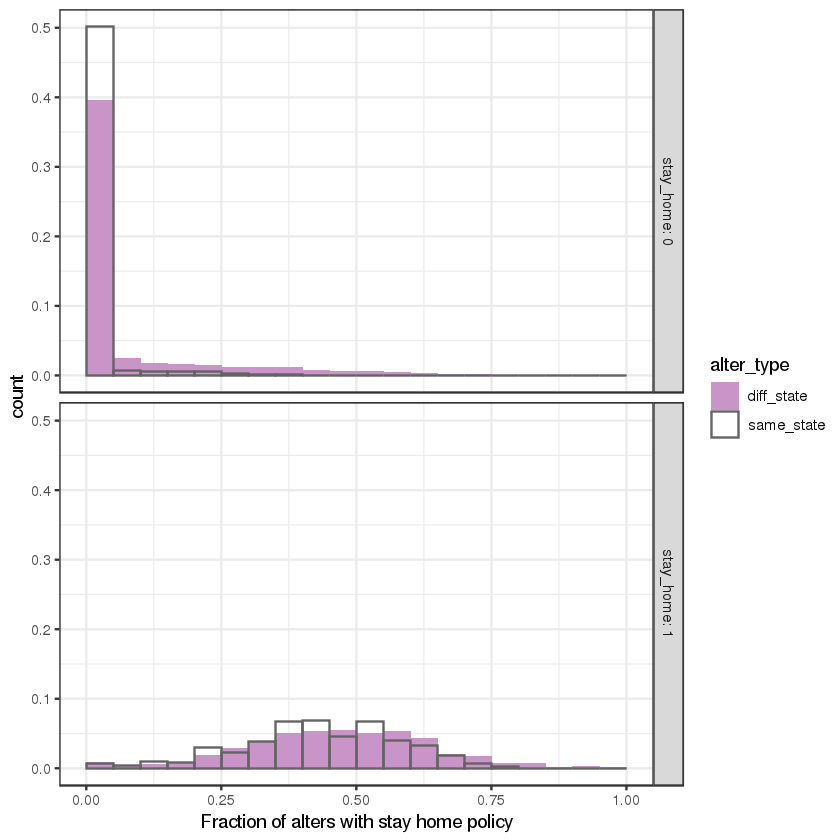

In [450]:
same_diff_state_alters_stay_home_histograms <- panel %>%
    select(stay_home, alter_sh_same_state, alter_sh_diff_state, n) %>%
    mutate(
        w = n / sum(n)
    ) %>%
    gather(key = "alter_type", value = "alter_sh", -stay_home, -w, -n) %>%
    mutate(
        alter_type = gsub("alter_sh_", "", alter_type)
    ) %>%
    ggplot(aes(
        x = alter_sh, weight = w,
        fill = alter_type, color = alter_type)) +
    geom_histogram(
        breaks = seq(0, 1, by = .05), position = 'identity'
    ) +
    facet_grid(stay_home ~ ., labeller = label_both) +
    scale_fill_manual(values = alpha(alter_type_fills, c(0, 0, 0, 1))) +
    scale_color_manual(values = alpha(alter_type_colors, c(0, 0, 1, 0))) +
    xlab("Fraction of alters with stay home policy")
same_diff_state_alters_stay_home_histograms

In [451]:
ggsave(
  paste0("../output/same_diff_state_alters_stay_home_histograms.pdf"),
  plot = same_diff_state_alters_stay_home_histograms,
  scale = 1.2,
  width = 5,
  height = 5,
  limitsize = FALSE,
  useDingbats = FALSE
)

## Diff-in-diff model with various spillovers from peer polices
This is just working with one example model here. Should be synchronized with rest of analysis as finalized.

In [268]:
DID.ITT.sg_nhd <- felm(log_sg_nhd.r ~ 0 +
               ban_gmr.r +
               stay_home.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

DID.ITT.sg_cbgv <- felm(log_sg_cbgv.r ~ 0 +
               ban_gmr.r +
               stay_home.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

DID.ITT.fb_rnstu <- felm(log_fb_rnstu.r ~ 0 +
               ban_gmr.r +
               stay_home.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

DID.ITT.fb_btvrc <- felm(fb_btvrc.r ~ 0 +
               ban_gmr.r +
               stay_home.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

In [264]:
summary(DID.ITT.sg_nhd)


Call:
   felm(formula = log_sg_nhd.r ~ 0 + ban_gmr.r + stay_home.r | county_fips +      ds | 0 | state_abbv, data = panel.r, weights = panel.r$n,      keepCX = T) 

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-278.15   -7.13    0.57    7.30  308.32 

Coefficients:
            Estimate Cluster s.e. t value Pr(>|t|)    
ban_gmr.r   -0.00398      0.00434   -0.92     0.36    
stay_home.r -0.05333      0.00687   -7.76  3.9e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.4 on 120046 degrees of freedom
Multiple R-squared(full model): 0.381   Adjusted R-squared: 0.368 
Multiple R-squared(proj model): 0.0592   Adjusted R-squared: 0.0392 
F-statistic(full model, *iid*):  29 on 2551 and 120046 DF, p-value: <2e-16 
F-statistic(proj model): 38.7 on 2 and 50 DF, p-value: 7.03e-11 



In [273]:
lfe::waldtest(DID.ITT.sg_nhd, "stay_home.r")

p     chi2      df1      p.F        F      df2 
8.44e-15 6.02e+01 1.00e+00 3.90e-10 6.02e+01 5.00e+01 
attr(,"formula")
~stay_home.r
<environment: 0xb6a3738>

In [276]:
felm.waldtest.mod(DID.ITT.sg_nhd, vcov(DID.ITT.sg_nhd), ~ stay_home.r)

beta        se         p      chi2       df1       p.F         F       df2 
-5.33e-02  6.87e-03  8.44e-15  6.02e+01  1.00e+00  3.90e-10  6.02e+01  5.00e+01 
attr(,"formula")
~stay_home.r
<environment: 0x7271e570>

In [248]:
DID.mp.gITT.sg_nhd <- felm(log_sg_nhd.r ~ 0 +
               ban_gmr.r + geo_alter_bgmr.r +
               stay_home.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

DID.mp.gITT.sg_cbgv <- felm(log_sg_cbgv.r ~ 0 +
               ban_gmr.r + geo_alter_bgmr.r +
               stay_home.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

DID.mp.gITT.fb_rnstu <- felm(log_fb_rnstu.r ~ 0 +
               ban_gmr.r + geo_alter_bgmr.r +
               stay_home.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

DID.mp.gITT.fb_btvrc <- felm(fb_btvrc.r ~ 0 +
               ban_gmr.r + geo_alter_bgmr.r +
               stay_home.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

In [249]:
DID.mp.aITT.sg_nhd <- felm(log_sg_nhd.r ~ 0 +
               ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r +
               stay_home.r + alter_sh.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)
DID.mp.aITT.sg_nhd.no_fe <- felm(log_sg_nhd.r ~ 0 +
               ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r +
               stay_home.r + alter_sh.r + geo_alter_sh.r | 0 | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

summary(DID.mp.aITT.sg_nhd)
summary(DID.mp.aITT.sg_nhd.no_fe)


Call:
   felm(formula = log_sg_nhd.r ~ 0 + ban_gmr.r + alter_bgmr.r +      geo_alter_bgmr.r + stay_home.r + alter_sh.r + geo_alter_sh.r |      county_fips + ds | 0 | state_abbv, data = panel.r, weights = panel.r$n,      keepCX = T) 

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-276.29   -7.07    0.41    7.22  303.73 

Coefficients:
                 Estimate Cluster s.e. t value Pr(>|t|)  
ban_gmr.r        -0.00342      0.00551   -0.62    0.538  
alter_bgmr.r      0.02120      0.02228    0.95    0.346  
geo_alter_bgmr.r -0.01932      0.01490   -1.30    0.201  
stay_home.r      -0.01626      0.00802   -2.03    0.048 *
alter_sh.r       -0.07873      0.03556   -2.21    0.031 *
geo_alter_sh.r   -0.01611      0.01672   -0.96    0.340  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.3 on 120042 degrees of freedom
Multiple R-squared(full model): 0.39   Adjusted R-squared: 0.377 
Multiple R-squared(proj model): 0.0731   Adjusted


Call:
   felm(formula = log_sg_nhd.r ~ 0 + ban_gmr.r + alter_bgmr.r +      geo_alter_bgmr.r + stay_home.r + alter_sh.r + geo_alter_sh.r |      0 | 0 | state_abbv, data = panel.r, weights = panel.r$n,      keepCX = T) 

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-350.8   -5.5   -0.2    5.5  370.6 

Coefficients:
                  Estimate Cluster s.e. t value Pr(>|t|)   
ban_gmr.r         0.000675     0.005712    0.12   0.9060   
alter_bgmr.r     -0.004495     0.021568   -0.21   0.8349   
geo_alter_bgmr.r -0.013500     0.014908   -0.91   0.3652   
stay_home.r      -0.004346     0.010839   -0.40   0.6884   
alter_sh.r       -0.215365     0.066189   -3.25   0.0011 **
geo_alter_sh.r    0.020283     0.030389    0.67   0.5045   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.3 on 122592 degrees of freedom
Multiple R-squared(full model): 0.129   Adjusted R-squared: 0.129 
Multiple R-squared(proj model): 0.129   Adjusted R-squared:

In [250]:
DID.mp.aITT.sg_nhd <- felm(log_sg_nhd.r ~ 0 +
               ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r +
               stay_home.r + alter_sh.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

DID.mp.aITT.sg_cbgv <- felm(log_sg_cbgv.r ~ 0 +
               ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r +
               stay_home.r + alter_sh.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

DID.mp.aITT.fb_rnstu <- felm(log_fb_rnstu.r ~ 0 +
               ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r +
               stay_home.r + alter_sh.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

DID.mp.aITT.fb_btvrc <- felm(fb_btvrc.r ~ 0 +
               ban_gmr.r + alter_bgmr.r + geo_alter_bgmr.r +
               stay_home.r + alter_sh.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv, 
                          panel.r, keepCX = T, weights = panel.r$n)

In [251]:
summary(DID.mp.gITT.fb_rnstu)
summary(DID.mp.aITT.fb_rnstu)


Call:
   felm(formula = log_fb_rnstu.r ~ 0 + ban_gmr.r + geo_alter_bgmr.r +      stay_home.r + geo_alter_sh.r | county_fips + ds | 0 | state_abbv,      data = panel.r, weights = panel.r$n, keepCX = T) 

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-338.0   -4.1    0.2    4.1  266.8 

Coefficients:
                 Estimate Cluster s.e. t value Pr(>|t|)    
ban_gmr.r        -0.00893      0.00407   -2.19    0.033 *  
geo_alter_bgmr.r  0.02310      0.01042    2.22    0.031 *  
stay_home.r      -0.02783      0.00517   -5.38    2e-06 ***
geo_alter_sh.r   -0.00698      0.00655   -1.07    0.291    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.3 on 120044 degrees of freedom
Multiple R-squared(full model): 0.367   Adjusted R-squared: 0.354 
Multiple R-squared(proj model): 0.0731   Adjusted R-squared: 0.0534 
F-statistic(full model, *iid*):27.3 on 2553 and 120044 DF, p-value: <2e-16 
F-statistic(proj model): 13.1 on 4 and 50 DF, p-va


Call:
   felm(formula = log_fb_rnstu.r ~ 0 + ban_gmr.r + alter_bgmr.r +      geo_alter_bgmr.r + stay_home.r + alter_sh.r + geo_alter_sh.r |      county_fips + ds | 0 | state_abbv, data = panel.r, weights = panel.r$n,      keepCX = T) 

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-338.9   -4.0    0.0    4.1  264.3 

Coefficients:
                 Estimate Cluster s.e. t value Pr(>|t|)   
ban_gmr.r        -0.00388      0.00464   -0.84    0.407   
alter_bgmr.r     -0.02400      0.01730   -1.39    0.171   
geo_alter_bgmr.r  0.03033      0.01467    2.07    0.044 * 
stay_home.r      -0.00737      0.00687   -1.07    0.289   
alter_sh.r       -0.10481      0.03365   -3.11    0.003 **
geo_alter_sh.r    0.03632      0.01715    2.12    0.039 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.2 on 120042 degrees of freedom
Multiple R-squared(full model): 0.376   Adjusted R-squared: 0.363 
Multiple R-squared(proj model): 0.0858   Adjusted

In [252]:
out_hd_aitt_sg$ct


t test of coefficients:

                  Estimate Std. Error t value Pr(>|t|)    
ban_gmr.r         6.75e-04   9.19e-05    7.35  2.1e-13 ***
alter_bgmr.r     -4.50e-03   2.76e-04  -16.26  < 2e-16 ***
geo_alter_bgmr.r -1.35e-02   1.96e-04  -68.78  < 2e-16 ***
stay_home.r      -4.35e-03   3.65e-04  -11.92  < 2e-16 ***
alter_sh.r       -2.15e-01   3.99e-03  -53.95  < 2e-16 ***
geo_alter_sh.r    2.03e-02   1.46e-03   13.92  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [459]:
# split in- and out-of-state alters
DID.mp.aITT.sg_nhd.split <- felm(
    log_sg_nhd.r ~ 0 +
    ban_gmr.r + stay_home.r +
    alter_ban_gmr_same_state.r + alter_ban_gmr_diff_state.r +
    geo_alter_ban_gmr_same_state.r + geo_alter_ban_gmr_diff_state.r +
    alter_sh_same_state.r + alter_sh_diff_state.r +
    geo_alter_sh_same_state.r + geo_alter_sh_diff_state.r
    | county_fips + ds | 0 | state_abbv, 
    panel.r, keepCX = T, weights = panel.r$n
)

DID.mp.aITT.sg_cbgv.split <- felm(
    log_sg_cbgv.r ~ 0 +
    ban_gmr.r + stay_home.r +
    alter_ban_gmr_same_state.r + alter_ban_gmr_diff_state.r +
    geo_alter_ban_gmr_same_state.r + geo_alter_ban_gmr_diff_state.r +
    alter_sh_same_state.r + alter_sh_diff_state.r +
    geo_alter_sh_same_state.r + geo_alter_sh_diff_state.r
    | county_fips + ds | 0 | state_abbv, 
    panel.r, keepCX = T, weights = panel.r$n
)

DID.mp.aITT.fb_rnstu.split <- felm(
    log_fb_rnstu.r ~ 0 +
    ban_gmr.r + stay_home.r +
    alter_ban_gmr_same_state.r + alter_ban_gmr_diff_state.r +
    geo_alter_ban_gmr_same_state.r + geo_alter_ban_gmr_diff_state.r +
    alter_sh_same_state.r + alter_sh_diff_state.r +
    geo_alter_sh_same_state.r + geo_alter_sh_diff_state.r
    | county_fips + ds | 0 | state_abbv, 
    panel.r, keepCX = T, weights = panel.r$n
)

DID.mp.aITT.fb_btvrc.split <- felm(
    fb_btvrc.r ~ 0 +
    ban_gmr.r + stay_home.r +
    alter_ban_gmr_same_state.r + alter_ban_gmr_diff_state.r +
    geo_alter_ban_gmr_same_state.r + geo_alter_ban_gmr_diff_state.r +
    alter_sh_same_state.r + alter_sh_diff_state.r +
    geo_alter_sh_same_state.r + geo_alter_sh_diff_state.r
    | county_fips + ds | 0 | state_abbv, 
    panel.r, keepCX = T, weights = panel.r$n
)

In [460]:
summary(DID.mp.aITT.sg_nhd.split)
summary(DID.mp.aITT.fb_rnstu.split)
vcov(DID.mp.aITT.fb_rnstu.split)


Call:
   felm(formula = log_sg_nhd.r ~ 0 + ban_gmr.r + stay_home.r + alter_ban_gmr_same_state.r +      alter_ban_gmr_diff_state.r + geo_alter_ban_gmr_same_state.r +      geo_alter_ban_gmr_diff_state.r + alter_sh_same_state.r +      alter_sh_diff_state.r + geo_alter_sh_same_state.r + geo_alter_sh_diff_state.r |      county_fips + ds | 0 | state_abbv, data = panel.r, weights = panel.r$n,      keepCX = T) 

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-248.74   -5.84    0.41    6.12  272.08 

Coefficients:
                               Estimate Cluster s.e. t value Pr(>|t|)   
ban_gmr.r                       0.00517      0.01047    0.49   0.6232   
stay_home.r                    -0.02451      0.01284   -1.91   0.0619 . 
alter_ban_gmr_same_state.r      0.01595      0.04195    0.38   0.7054   
alter_ban_gmr_diff_state.r     -0.05932      0.04904   -1.21   0.2321   
geo_alter_ban_gmr_same_state.r -0.03086      0.02142   -1.44   0.1559   
geo_alter_ban_gmr_diff_state.r  0.04


Call:
   felm(formula = log_fb_rnstu.r ~ 0 + ban_gmr.r + stay_home.r +      alter_ban_gmr_same_state.r + alter_ban_gmr_diff_state.r +      geo_alter_ban_gmr_same_state.r + geo_alter_ban_gmr_diff_state.r +      alter_sh_same_state.r + alter_sh_diff_state.r + geo_alter_sh_same_state.r +      geo_alter_sh_diff_state.r | county_fips + ds | 0 | state_abbv,      data = panel.r, weights = panel.r$n, keepCX = T) 

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-322.8   -3.1    0.1    3.2  246.6 

Coefficients:
                               Estimate Cluster s.e. t value Pr(>|t|)   
ban_gmr.r                       0.00316      0.00884    0.36   0.7218   
stay_home.r                    -0.01223      0.01024   -1.19   0.2379   
alter_ban_gmr_same_state.r     -0.03290      0.04198   -0.78   0.4369   
alter_ban_gmr_diff_state.r     -0.07988      0.03675   -2.17   0.0345 * 
geo_alter_ban_gmr_same_state.r  0.02454      0.02259    1.09   0.2825   
geo_alter_ban_gmr_diff_state.r  0.05629     

,ban_gmr.r,stay_home.r,alter_ban_gmr_same_state.r,alter_ban_gmr_diff_state.r,geo_alter_ban_gmr_same_state.r,geo_alter_ban_gmr_diff_state.r,alter_sh_same_state.r,alter_sh_diff_state.r,geo_alter_sh_same_state.r,geo_alter_sh_diff_state.r
ban_gmr.r,7.81e-05,8.02e-05,-0.000342,-0.000214,0.000160,0.000170,-0.000393,-0.000557,0.000150,0.000361
stay_home.r,8.02e-05,1.05e-04,-0.000377,-0.000281,0.000191,0.000199,-0.000502,-0.000774,0.000198,0.000457
alter_ban_gmr_same_state.r,-3.42e-04,-3.77e-04,0.001763,0.001228,-0.000908,-0.000945,0.002138,0.003231,-0.000888,-0.002016
alter_ban_gmr_diff_state.r,-2.14e-04,-2.81e-04,0.001228,0.001350,-0.000702,-0.000894,0.001561,0.002966,-0.000652,-0.001788
geo_alter_ban_gmr_same_state.r,1.60e-04,1.91e-04,-0.000908,-0.000702,0.000510,0.000519,-0.001163,-0.001799,0.000513,0.001084
geo_alter_ban_gmr_diff_state.r,1.70e-04,1.99e-04,-0.000945,-0.000894,0.000519,0.000672,-0.001152,-0.002067,0.000479,0.001322
alter_sh_same_state.r,-3.93e-04,-5.02e-04,0.002138,0.001561,-0.001163,-0.001152,0.002903,0.004377,-0.001246,-0.002583
alter_sh_diff_state.r,-5.57e-04,-7.74e-04,0.003231,0.002966,-0.001799,-0.002067,0.004377,0.007744,-0.001854,-0.004572
geo_alter_sh_same_state.r,1.50e-04,1.98e-04,-0.000888,-0.000652,0.000513,0.000479,-0.001246,-0.001854,0.000573,0.001068
geo_alter_sh_diff_state.r,3.61e-04,4.57e-04,-0.002016,-0.001788,0.001084,0.001322,-0.002583,-0.004572,0.001068,0.002946


## Tests of some contrasts including combined spillovers etc.

In [353]:
source("../utils/labels_and_colors.r")
source("../utils/geo_utils.r")
source("../utils/adjacency_and_cluster_robust_inference.R")
source("../utils/contrasts.r")

In [314]:
# contrast with models without spillovers
pc_same_state_no_spillovers <- policy_contrast_linear_many_models(
    list(DID.ITT.sg_nhd, DID.ITT.sg_cbgv,
         DID.ITT.fb_rnstu, DID.ITT.fb_btvrc),
    panel.r %>% mutate(
        stay_home.r = 1
    ),
    panel.r %>% mutate(
        stay_home.r = 0
    ),
    weights = panel.r$n,
    policy = "Shelter-in-place order in own state",
    model = "No spillovers"
)
pc_same_state_no_spillovers

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


beta,se,p,chi2,df1,p.F,F,df2,formula,lhs,policy,model
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
-0.0533,0.00687,8.44e-15,60.2,1,3.90e-10,60.2,50,~ 1 * stay_home.r,log_sg_nhd.r,Shelter-in-place order in own state,No spillovers
-0.0538,0.00636,2.73e-17,71.5,1,3.29e-11,71.5,50,~ 1 * stay_home.r,log_sg_cbgv.r,Shelter-in-place order in own state,No spillovers
-0.0280,0.00487,8.61e-09,33.1,1,5.23e-07,33.1,50,~ 1 * stay_home.r,log_fb_rnstu.r,Shelter-in-place order in own state,No spillovers
-0.0741,0.00574,5.00e-38,166.2,1,1.61e-17,166.2,50,~ 1 * stay_home.r,fb_btvrc.r,Shelter-in-place order in own state,No spillovers


In [315]:
# simple test accounting for spillovers
pc_same_state <- policy_contrast_linear_many_models(
    list(DID.mp.aITT.sg_nhd, DID.mp.aITT.sg_cbgv,
         DID.mp.aITT.fb_rnstu, DID.mp.aITT.fb_btvrc),
    panel.r %>% mutate(
        stay_home.r = 1, 
        alter_sh.r = panel$alter_same_state, 
        geo_alter_sh.r = panel$geo_alter_same_state
    ),
    panel.r %>% mutate(
        stay_home.r = 0,
        alter_sh.r = 0, 
        geo_alter_sh.r = 0
    ),
    weights = panel.r$n,
    policy = "Shelter-in-place order in own state",
    model = "Social and geo spillovers"
)
pc_same_state

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


beta,se,p,chi2,df1,p.F,F,df2,formula,lhs,policy,model
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
-0.0675,0.00927,3.33e-13,53.0,1,2.19e-09,53.0,50,~ 1 * stay_home.r + 0.538012982723574 * alter_sh.r + 0.551917304210717 * geo_alter_sh.r,log_sg_nhd.r,Shelter-in-place order in own state,Social and geo spillovers
-0.0664,0.00740,3.00e-19,80.4,1,5.49e-12,80.4,50,~ 1 * stay_home.r + 0.538012982723574 * alter_sh.r + 0.551917304210717 * geo_alter_sh.r,log_sg_cbgv.r,Shelter-in-place order in own state,Social and geo spillovers
-0.0437,0.00630,3.93e-12,48.2,1,7.45e-09,48.2,50,~ 1 * stay_home.r + 0.538012982723574 * alter_sh.r + 0.551917304210717 * geo_alter_sh.r,log_fb_rnstu.r,Shelter-in-place order in own state,Social and geo spillovers
-0.1013,0.00879,1.00e-30,132.8,1,1.10e-15,132.8,50,~ 1 * stay_home.r + 0.538012982723574 * alter_sh.r + 0.551917304210717 * geo_alter_sh.r,fb_btvrc.r,Shelter-in-place order in own state,Social and geo spillovers


In [321]:
# geo spillover effect of all other states adopting stay at home orders
pc_out_of_state_geo_alter_policies_all_geo_only <- policy_contrast_linear_many_models(
    list(DID.mp.gITT.sg_nhd, DID.mp.gITT.sg_cbgv,
         DID.mp.gITT.fb_rnstu, DID.mp.gITT.fb_btvrc),
    panel.r %>% mutate(geo_alter_sh.r = 1),
    panel.r %>% mutate(geo_alter_sh.r = panel$geo_alter_same_state),
    weights = panel.r$n,
    policy = "Total spillovers of shelter-in-place order in all other states",
    model = "Geo spillovers only"
)
pc_out_of_state_geo_alter_policies_all_geo_only

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


beta,se,p,chi2,df1,p.F,F,df2,formula,lhs,policy,model
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
-0.02220,0.00381,5.50e-09,34.00,1,4.00e-07,34.00,50,~ 0.448082695789283 * geo_alter_sh.r,log_sg_nhd.r,Total spillovers of shelter-in-place order in all other states,Geo spillovers only
-0.02229,0.00427,1.75e-07,27.29,1,3.41e-06,27.29,50,~ 0.448082695789283 * geo_alter_sh.r,log_sg_cbgv.r,Total spillovers of shelter-in-place order in all other states,Geo spillovers only
-0.00313,0.00294,2.86e-01,1.14,1,2.91e-01,1.14,50,~ 0.448082695789283 * geo_alter_sh.r,log_fb_rnstu.r,Total spillovers of shelter-in-place order in all other states,Geo spillovers only
-0.01845,0.00557,9.32e-04,10.96,1,1.73e-03,10.96,50,~ 0.448082695789283 * geo_alter_sh.r,fb_btvrc.r,Total spillovers of shelter-in-place order in all other states,Geo spillovers only


In [317]:
# geo spillover effect of all other states adopting stay at home orders
pc_out_of_state_geo_alter_policies_all <- policy_contrast_linear_many_models(
    list(DID.mp.aITT.sg_nhd, DID.mp.aITT.sg_cbgv,
         DID.mp.aITT.fb_rnstu, DID.mp.aITT.fb_btvrc),
    panel.r %>% mutate(geo_alter_sh.r = 1),
    panel.r %>% mutate(geo_alter_sh.r = panel$geo_alter_same_state),
    weights = panel.r$n,
    policy = "Geo spillovers of shelter-in-place order in all other states",
    model = "Social and geo spillovers"
)
pc_out_of_state_geo_alter_policies_all

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


beta,se,p,chi2,df1,p.F,F,df2,formula,lhs,policy,model
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
-0.00722,0.00749,0.3354,0.928,1,0.3400,0.928,50,~ 0.448082695789283 * geo_alter_sh.r,log_sg_nhd.r,Geo spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.00930,0.00785,0.2362,1.403,1,0.2418,1.403,50,~ 0.448082695789283 * geo_alter_sh.r,log_sg_cbgv.r,Geo spillovers of shelter-in-place order in all other states,Social and geo spillovers
0.01627,0.00769,0.0342,4.483,1,0.0392,4.483,50,~ 0.448082695789283 * geo_alter_sh.r,log_fb_rnstu.r,Geo spillovers of shelter-in-place order in all other states,Social and geo spillovers
0.01784,0.00943,0.0587,3.575,1,0.0645,3.575,50,~ 0.448082695789283 * geo_alter_sh.r,fb_btvrc.r,Geo spillovers of shelter-in-place order in all other states,Social and geo spillovers


In [318]:
# SCI spillover effect of all other states adopting stay at home orders
pc_out_of_state_sci_alter_policies_all <- policy_contrast_linear_many_models(
    list(DID.mp.aITT.sg_nhd, DID.mp.aITT.sg_cbgv,
         DID.mp.aITT.fb_rnstu, DID.mp.aITT.fb_btvrc),
    panel.r %>% mutate(alter_bg.r = 1, alter_bgmr.r = 1, alter_sh.r = 1),
    panel.r %>% mutate(
        alter_bg.r = panel$alter_same_state,
        alter_bgmr.r = panel$alter_same_state,
        alter_sh.r = panel$alter_same_state
    ),
    weights = panel.r$n,
    policy = "Social spillovers of shelter-in-place order in all other states",
    model = "Social and geo spillovers"
)
pc_out_of_state_sci_alter_policies_all

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


beta,se,p,chi2,df1,p.F,F,df2,formula,lhs,policy,model
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
-0.0266,0.0246,2.80e-01,1.17,1,2.85e-01,1.17,50,~ 0.461987017276426 * alter_bgmr.r + 0.461987017276426 * alter_sh.r,log_sg_nhd.r,Social spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.0371,0.0249,1.36e-01,2.22,1,1.42e-01,2.22,50,~ 0.461987017276426 * alter_bgmr.r + 0.461987017276426 * alter_sh.r,log_sg_cbgv.r,Social spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.0595,0.0226,8.54e-03,6.92,1,1.13e-02,6.92,50,~ 0.461987017276426 * alter_bgmr.r + 0.461987017276426 * alter_sh.r,log_fb_rnstu.r,Social spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.1228,0.0261,2.50e-06,22.17,1,2.02e-05,22.17,50,~ 0.461987017276426 * alter_bgmr.r + 0.461987017276426 * alter_sh.r,fb_btvrc.r,Social spillovers of shelter-in-place order in all other states,Social and geo spillovers


In [320]:
# SCI+geo spillover effect of all other states adopting stay at home orders
pc_out_of_state_geo_sci_alter_policies_all <- policy_contrast_linear_many_models(
    list(DID.mp.aITT.sg_nhd, DID.mp.aITT.sg_cbgv,
         DID.mp.aITT.fb_rnstu, DID.mp.aITT.fb_btvrc),
    panel.r %>% mutate(
        alter_bgmr.r = 1, alter_sh.r = 1,
        geo_alter_bgmr.r = 1, geo_alter_sh.r = 1
    ),
    panel.r %>% mutate(
        alter_bgmr.r = panel$alter_same_state,
        alter_sh.r = panel$alter_same_state,
        geo_alter_bgmr.r = panel$geo_alter_same_state,
        geo_alter_sh.r = panel$geo_alter_same_state
    ),
    weights = panel.r$n,
    policy = "Total spillovers of shelter-in-place order in all other states",
    model = "Social and geo spillovers"
)
pc_out_of_state_geo_sci_alter_policies_all

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


beta,se,p,chi2,df1,p.F,F,df2,formula,lhs,policy,model
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
-0.0425,0.0146,3.63e-03,8.46,1,5.40e-03,8.46,50,~ 0.461987017276426 * alter_bgmr.r + 0.448082695789283 * geo_alter_bgmr.r + 0.461987017276426 * alter_sh.r + 0.448082695789283 * geo_alter_sh.r,log_sg_nhd.r,Total spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.0505,0.0145,5.15e-04,12.06,1,1.07e-03,12.06,50,~ 0.461987017276426 * alter_bgmr.r + 0.448082695789283 * geo_alter_bgmr.r + 0.461987017276426 * alter_sh.r + 0.448082695789283 * geo_alter_sh.r,log_sg_cbgv.r,Total spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.0296,0.0109,6.75e-03,7.34,1,9.22e-03,7.34,50,~ 0.461987017276426 * alter_bgmr.r + 0.448082695789283 * geo_alter_bgmr.r + 0.461987017276426 * alter_sh.r + 0.448082695789283 * geo_alter_sh.r,log_fb_rnstu.r,Total spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.0956,0.0151,2.66e-10,39.91,1,7.01e-08,39.91,50,~ 0.461987017276426 * alter_bgmr.r + 0.448082695789283 * geo_alter_bgmr.r + 0.461987017276426 * alter_sh.r + 0.448082695789283 * geo_alter_sh.r,fb_btvrc.r,Total spillovers of shelter-in-place order in all other states,Social and geo spillovers


In [479]:
# SCI+geo spillover effect of all other states adopting stay at home orders
# from model with split in- and out-of-state alters
panel.r$alter_same_state <- panel$alter_same_state
panel.r$geo_alter_same_state <- panel$geo_alter_same_state

pc_out_of_state_geo_sci_alter_policies_all_split <- policy_contrast_linear_many_models(
    list(DID.mp.aITT.sg_nhd.split, DID.mp.aITT.sg_cbgv.split,
         DID.mp.aITT.fb_rnstu.split, DID.mp.aITT.fb_btvrc.split),
    panel.r %>% mutate(
        geo_alter_ban_gmr_same_state.r = geo_alter_same_state,
        geo_alter_ban_gmr_diff_state.r = 1-geo_alter_same_state,
        alter_ban_gmr_same_state.r = alter_same_state,
        alter_ban_gmr_diff_state.r = 1-alter_same_state,
        geo_alter_sh_same_state.r = geo_alter_same_state,
        geo_alter_sh_diff_state.r = 1-geo_alter_same_state,
        alter_sh_same_state.r = alter_same_state,
        alter_sh_diff_state.r = 1-alter_same_state
    ),
    panel.r %>% mutate(
        geo_alter_ban_gmr_same_state.r = geo_alter_same_state,
        geo_alter_ban_gmr_diff_state.r = 0,
        alter_ban_gmr_same_state.r = alter_same_state,
        alter_ban_gmr_diff_state.r = 0,
        geo_alter_sh_same_state.r = geo_alter_same_state,
        geo_alter_sh_diff_state.r = 0,
        alter_sh_same_state.r = alter_same_state,
        alter_sh_diff_state.r = 0
    ),
    weights = panel.r$n,
    policy = "Total spillovers of shelter-in-place order in all other states",
    model = "Social and geo spillovers"
)
pc_out_of_state_geo_sci_alter_policies_all_split

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


beta,se,p,chi2,df1,p.F,F,df2,formula,lhs,policy,model
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
-0.0831,0.0330,0.011641,6.36,1,0.014869,6.36,50,~ 0.461987017276426 * alter_ban_gmr_diff_state.r + 0.448082695789283 * geo_alter_ban_gmr_diff_state.r + 0.461987017276426 * alter_sh_diff_state.r + 0.448082695789283 * geo_alter_sh_diff_state.r,log_sg_nhd.r,Total spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.0308,0.0284,0.278863,1.17,1,0.284058,1.17,50,~ 0.461987017276426 * alter_ban_gmr_diff_state.r + 0.448082695789283 * geo_alter_ban_gmr_diff_state.r + 0.461987017276426 * alter_sh_diff_state.r + 0.448082695789283 * geo_alter_sh_diff_state.r,log_sg_cbgv.r,Total spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.0848,0.0246,0.000567,11.88,1,0.001159,11.88,50,~ 0.461987017276426 * alter_ban_gmr_diff_state.r + 0.448082695789283 * geo_alter_ban_gmr_diff_state.r + 0.461987017276426 * alter_sh_diff_state.r + 0.448082695789283 * geo_alter_sh_diff_state.r,log_fb_rnstu.r,Total spillovers of shelter-in-place order in all other states,Social and geo spillovers
-0.1045,0.0298,0.000450,12.31,1,0.000962,12.31,50,~ 0.461987017276426 * alter_ban_gmr_diff_state.r + 0.448082695789283 * geo_alter_ban_gmr_diff_state.r + 0.461987017276426 * alter_sh_diff_state.r + 0.448082695789283 * geo_alter_sh_diff_state.r,fb_btvrc.r,Total spillovers of shelter-in-place order in all other states,Social and geo spillovers


In [480]:
pc1 <- bind_rows(
    pc_same_state_no_spillovers,
    pc_same_state,
    pc_out_of_state_geo_alter_policies_all_geo_only,
    #pc_out_of_state_geo_alter_policies_all,
    #pc_out_of_state_sci_alter_policies_all,
    #pc_out_of_state_geo_sci_alter_policies_all,
    pc_out_of_state_geo_sci_alter_policies_all_split
    )

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


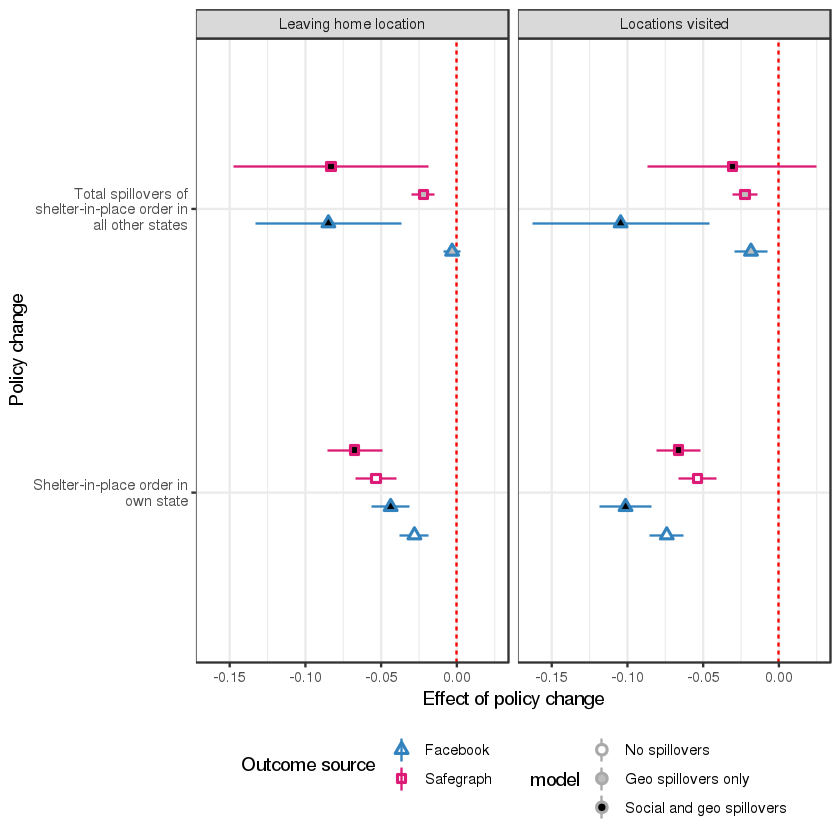

In [482]:
pc_alter_policies_all_plot <- pc1 %>%
    mutate(
        model = factor(model, levels = levels(factor(pc1$model))[c(2, 1, 3)])
    ) %>%
ggplot(
    aes(y = beta, ymin = beta - 1.96 * se, ymax = beta + 1.96 * se,
        x = str_wrap(policy, 26),
        color = get_outcome_source(outcome_labels[lhs]),
        shape = get_outcome_source(outcome_labels[lhs]),
        fill = model
       )
) +
geom_hline(yintercept = 0, color='red', linetype='dashed') +
geom_pointrange(
    position = position_dodge(width = .4)#, shape = 21
) +
facet_wrap(~ outcome_types[outcome_labels[lhs]]) +
scale_color_manual(name = "Outcome source", values = outcome_source_colors) +
scale_shape_manual(name = "Outcome source", values = outcome_source_shapes) +
scale_fill_manual(values = c("white", "grey", "black")) +
coord_flip() +
xlab("Policy change") +
ylab("Effect of policy change") +
theme(
    #legend.position = c(0.3, -.4),
    #plot.margin = margin(t = 2, l = 2, r = 2, b = 80, unit = "pt")
    legend.position = "bottom",
    legend.box = "horizontal"
) +
guides(
    color = guide_legend(nrow = 2),
    fill = guide_legend(
        nrow = 3,
        override.aes=list(shape = 21, color = "#aaaaaa")
    )
)
pc_alter_policies_all_plot

In [483]:
ggsave(
  paste0("../output/pc_alter_policies_all_dotplot.pdf"),
  plot = pc_alter_policies_all_plot,
  scale = 1.2,
  width = 5,
  height = 3.5,
  limitsize = FALSE,
  useDingbats = FALSE
)